# Dự án: Nhận diện và phân loại người đeo khẩu trang


Học viên thực hiện:
1. Võ Hoài Sơn
2. Nguyễn Trọng Nhân


# 1. Cài đặt và Import các thư viện cần thiết

In [1]:
!pip install -q mediapipe
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-cloud-bigtable 2.28.1 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.

In [2]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image

import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

2025-04-20 12:28:49.948051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745152130.149638      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745152130.206217      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745152140.585666     123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# 2. Chuẩn bị dữ liệu

In [3]:
def apply_offset(x, y, w, h, scale=1.2, frame_shape=(480, 640)):
    cx = x + w // 2
    cy = y + h // 2
    new_w = int(w * scale)
    new_h = int(h * scale)
    x1 = max(0, cx - new_w // 2)
    y1 = max(0, cy - new_h // 2)
    x2 = min(frame_shape[1], cx + new_w // 2)
    y2 = min(frame_shape[0], cy + new_h // 2)
    return x1, y1, x2 - x1, y2 - y1

def crop_face_from_image(path, output_size=224):
    img = cv2.imread(str(path))
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(img_rgb)
    if results.detections:
        bbox = results.detections[0].location_data.relative_bounding_box
        ih, iw, _ = img.shape
        x = int(bbox.xmin * iw)
        y = int(bbox.ymin * ih)
        w = int(bbox.width * iw)
        h = int(bbox.height * ih)
        x, y, w, h = apply_offset(x, y, w, h, scale=1.2, frame_shape=img.shape)
        roi = img[y:y+h, x:x+w]
        if roi.shape[0] == 0 or roi.shape[1] == 0:
            return None
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (output_size, output_size))
        rgb = np.stack([gray]*3, axis=-1)  # convert to RGB
        return rgb
    return None

In [4]:
def get_class_label(group, subclass):
    if group == "incorrect_mask":
        return f"incorrect_{subclass}"
    elif group == "with_mask":
        return f"mask_{subclass}"
    elif group == "without_mask":
        return f"no_mask_{subclass}"
    else:
        return None

def process_full_dataset(input_root, output_root, output_size=224):
    input_root = Path(input_root)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)
    total = 0
    for group_dir in input_root.iterdir():
        if not group_dir.is_dir():
            continue
        group_name = group_dir.name
        for class_dir in group_dir.iterdir():
            if not class_dir.is_dir():
                continue
            subclass_name = class_dir.name
            label = get_class_label(group_name, subclass_name)
            if label is None:
                continue
            output_class = output_root / label
            output_class.mkdir(parents=True, exist_ok=True)
            for img_path in tqdm(class_dir.glob("*.jpg"), desc=f"{label}"):
                rgb = crop_face_from_image(img_path, output_size=output_size)
                if rgb is not None:
                    out_path = output_class / img_path.name
                    cv2.imwrite(str(out_path), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
                    total += 1
    print(f"\n✅ Hoàn tất xử lý {total} ảnh")

In [5]:
# Gọi hàm xử lý tất cả ảnh:
input_root = "/kaggle/input/face-mask-dataset/FMD_DATASET"
output_root = "/kaggle/working/processed_6class"
process_full_dataset(input_root, output_root)

no_mask_simple: 4000it [00:44, 89.25it/s] 
no_mask_complex: 747it [00:09, 82.69it/s]
incorrect_mmc: 2500it [01:04, 38.65it/s]
incorrect_mc: 2500it [00:56, 44.37it/s]
mask_simple: 4000it [01:16, 52.00it/s]
mask_complex: 789it [00:10, 77.48it/s]


✅ Hoàn tất xử lý 14100 ảnh


In [12]:
from sklearn.model_selection import train_test_split

def split_dataset(src_root, dst_root, val_ratio=0.2, test_ratio=0.1):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(src_root):
            os.makedirs(dst_root / split / cls, exist_ok=True)
    for cls in os.listdir(src_root):
        files = list((src_root / cls).glob("*.jpg")) + list((src_root / cls).glob("*.png"))
        if len(files) == 0:
            print(f"⚠️ Bỏ qua lớp {cls} vì không có ảnh.")
            continue
        train_val, test = train_test_split(files, test_size=test_ratio, random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio/(1 - test_ratio), random_state=42)
        for f in train:
            shutil.copy(f, dst_root / 'train' / cls / f.name)
        for f in val:
            shutil.copy(f, dst_root / 'val' / cls / f.name)
        for f in test:
            shutil.copy(f, dst_root / 'test' / cls / f.name)

split_dataset("/kaggle/working/processed_6class", "/kaggle/working/dataset_split")


# 3. Load dữ liệu và hiển thị 

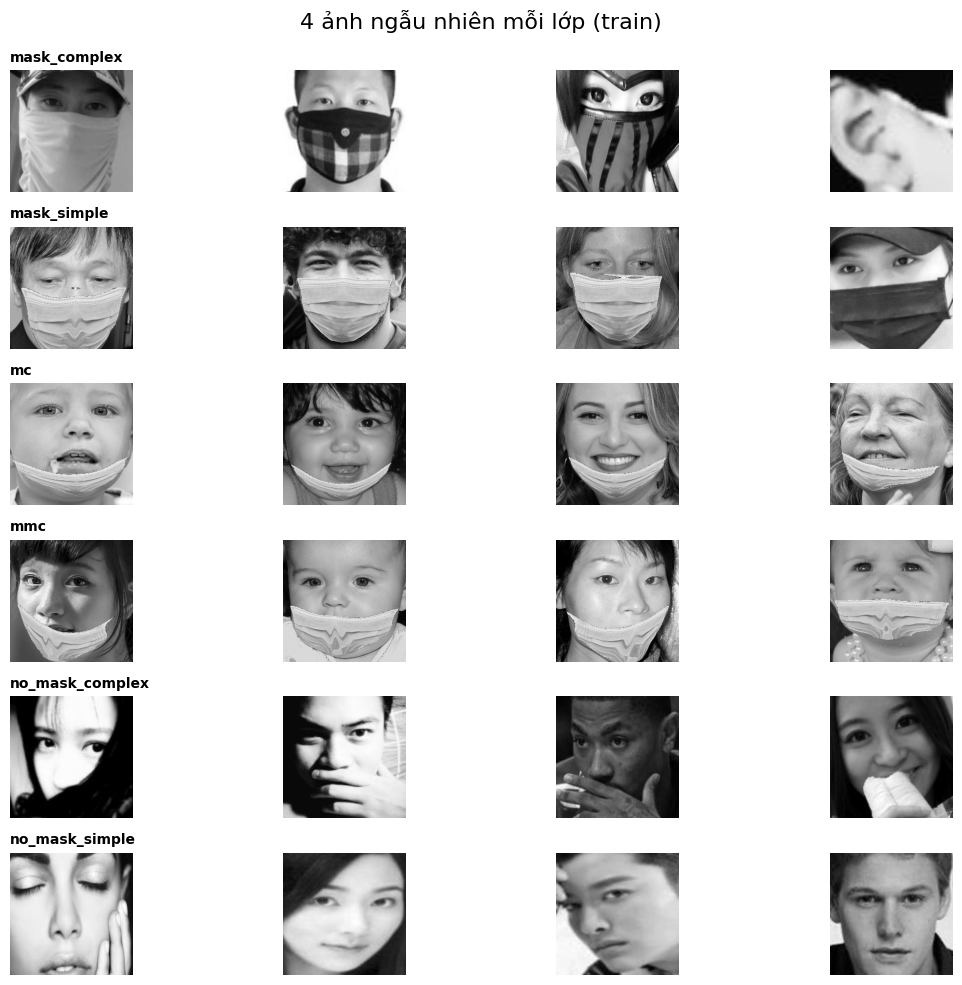

In [15]:
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path
import cv2

# Thư mục dataset train (sau khi chia xong)
root_dir = "/kaggle/working/dataset_split/train"

# Lấy danh sách class
class_names = sorted(os.listdir(root_dir))

# Thiết lập hiển thị: mỗi class 4 ảnh, 6 lớp → 6 hàng × 4 cột
fig, axes = plt.subplots(nrows=len(class_names), ncols=4, figsize=(12, 10))
fig.suptitle("Các ảnh của mỗi lớp (đã xử lý)", fontsize=16)

for row, cls in enumerate(class_names):
    class_path = Path(root_dir) / cls
    img_files = list(class_path.glob("*.jpg"))
    
    if len(img_files) < 4:
        samples = img_files  # nếu < 4 ảnh thì lấy hết
    else:
        samples = random.sample(img_files, 4)
    
    for col, img_path in enumerate(samples):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(cls, loc='left', fontsize=10, weight='bold')

# Nếu thiếu ảnh, ẩn ô còn lại
for row in range(len(class_names)):
    for col in range(4):
        if col >= len(list((Path(root_dir) / class_names[row]).glob("*.jpg"))):
            axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


# 4. Khởi tạo và huấn luyện mô hình

In [16]:
from ultralytics import YOLO
model = YOLO("yolov8n-cls.pt")
model.train(
    data="./dataset_split",
    epochs=30,
    imgsz=224,
    batch=32,
    patience=5,
    name="yolov8n-mask6class"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.31M/5.31M [00:00<00:00, 74.8MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=./dataset_split, epochs=30, time=None, patience=5, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n-mask6class, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 437.2±107.5 MB/s, size: 17.8 KB)


train: Scanning /kaggle/working/dataset_split/train... 9864 images, 0 corrupt: 100%|██████████| 9864/9864 [00:03<00:00, 2861.21it/s]

train: New cache created: /kaggle/working/dataset_split/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 273.3±91.6 MB/s, size: 15.1 KB)


val: Scanning /kaggle/working/dataset_split/val... 2823 images, 0 corrupt: 100%|██████████| 2823/2823 [00:00<00:00, 2982.01it/s]

val: New cache created: /kaggle/working/dataset_split/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolov8n-mask6class
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.426G       1.86         32        224:   2%|▏         | 5/309 [00:01<00:52,  5.80it/s]

       1/30     0.426G      1.855         32        224:   4%|▎         | 11/309 [00:01<00:34,  8.58it/s]
100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 13.99it/s]

                   all      0.953      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.22it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 13.91it/s]

                   all      0.949      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.19it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.06it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 13.96it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.19it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.22it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.40it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.537G    0.08889          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.21it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.537G    0.08075          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.47it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.537G    0.07724          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.42it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.537G    0.07957          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 13.78it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.537G    0.07097          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.07it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.537G    0.06157          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.13it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.537G    0.05998          8        224: 100%|██████████| 309/309 [00:30<00:00, 10.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 12.94it/s]

                   all       0.97          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.151 hours.
Optimizer stripped from runs/classify/yolov8n-mask6class/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/yolov8n-mask6class/weights/best.pt, 3.0MB

Validating runs/classify/yolov8n-mask6class/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,442,566 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/dataset_split/train... found 9864 images in 6 classes ✅ 
val: /kaggle/working/dataset_split/val... found 2823 images in 6 classes ✅ 
test: /kaggle/working/dataset_split/test... found 1413 images in 6 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 45/45 [00:03<00:00, 14.10it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.971          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolov8n-mask6class


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2bccc65150>
curves: []
curves_results: []
fitness: 0.9852993190288544
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9705986380577087, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9852993190288544}
save_dir: PosixPath('runs/classify/yolov8n-mask6class')
speed: {'preprocess': 0.07714417251109694, 'inference': 0.2329499263194748, 'loss': 0.0002626418705842721, 'postprocess': 0.00044216578134641233}
task: 'classify'
top1: 0.9705986380577087
top5: 1.0

# 5. Đánh giá mô hình trên tập test

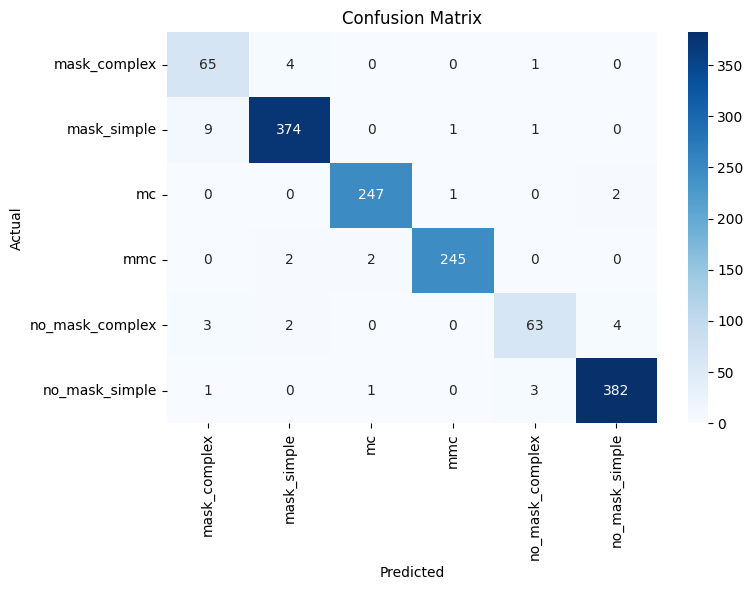

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


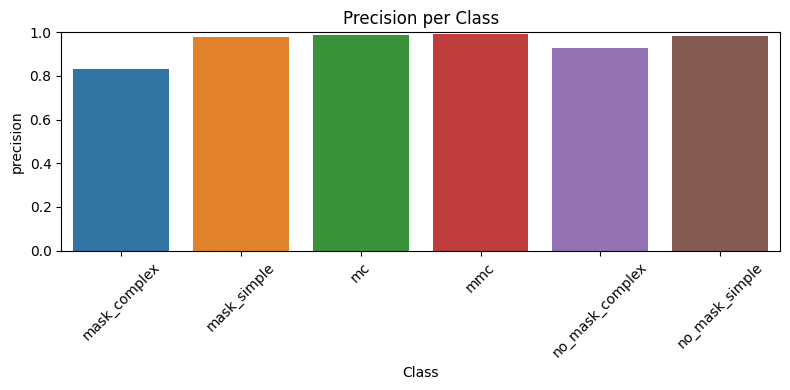

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


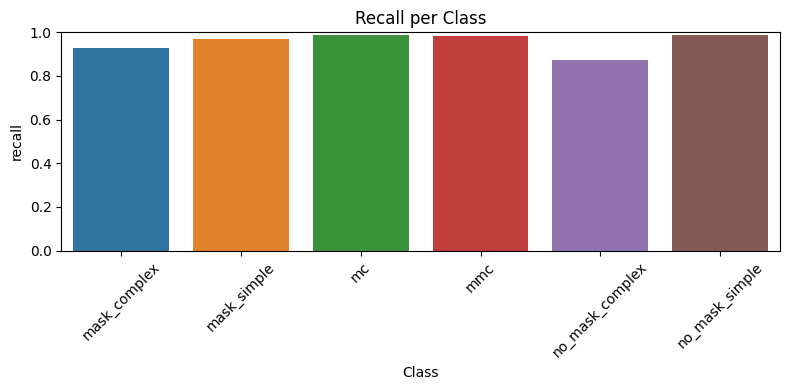

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


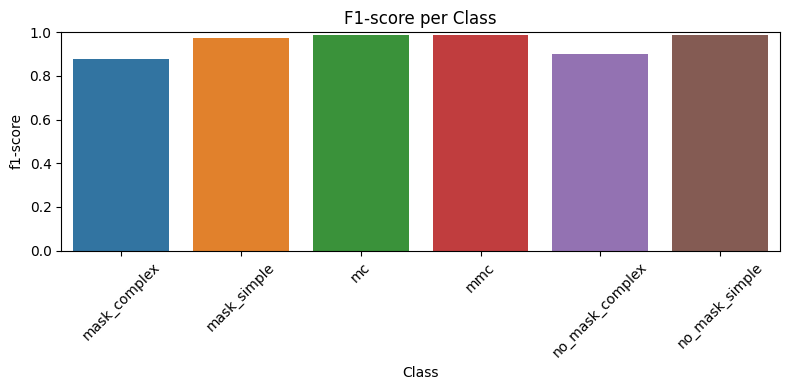

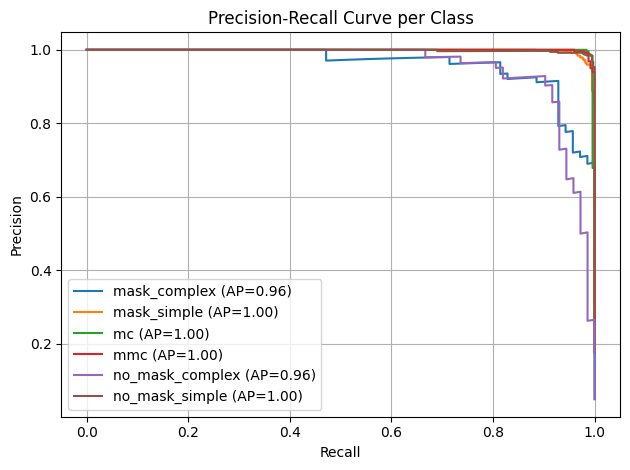

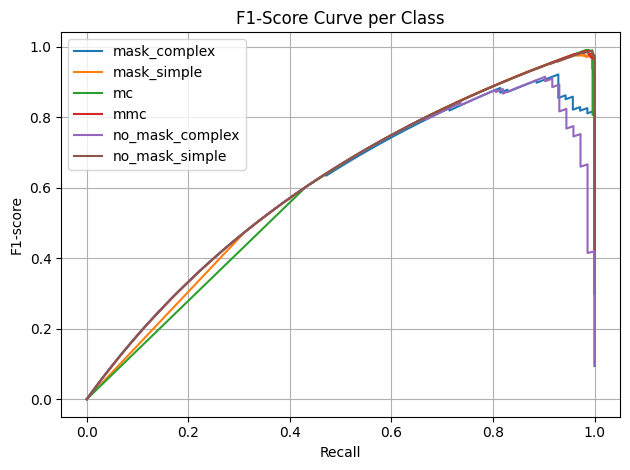

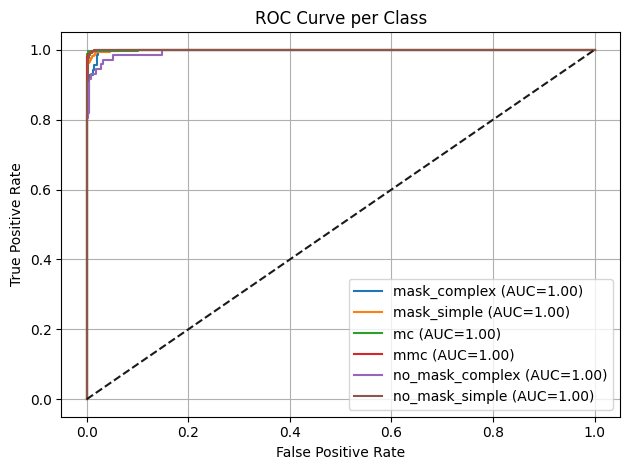

In [39]:
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score, roc_curve, auc
import seaborn as sns
import pandas as pd  # thêm pandas để xử lý biểu đồ báo cáo



model = YOLO("runs/classify/yolov8n-mask6class/weights/best.pt")
test_dir = Path("/kaggle/working/dataset_split/test")
y_true, y_pred, y_scores = [], [], []
class_names = list(model.names.values())

for class_id, class_name in enumerate(class_names):
    for img_path in (test_dir / class_name).glob("*.jpg"):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        img_rgb = np.stack([img]*3, axis=-1)
        result = model(img_rgb, verbose=False)
        probs = result[0].probs.data.cpu().numpy()
        pred = np.argmax(probs)

        y_true.append(class_id)
        y_pred.append(pred)
        y_scores.append(probs)

y_scores = np.array(y_scores)

# Vẽ confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report - vẽ từng biểu đồ riêng
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

metrics_to_plot = ["precision", "recall", "f1-score"]
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 4))
    values = [report[class_name][metric] for class_name in class_names]
    sns.barplot(x=class_names, y=values)
    plt.title(f"{metric.capitalize()} per Class")
    plt.ylabel(metric)
    plt.xlabel("Class")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Vẽ PR curve và F1-score curve cho từng lớp
from sklearn.preprocessing import label_binarize

n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1-score Curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    plt.plot(recall, f1_scores, label=f"{class_names[i]}")
plt.xlabel("Recall")
plt.ylabel("F1-score")
plt.title("F1-Score Curve per Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC Curve per class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()